# Creating a Pass Success Probability Metric with Decision Trees

In [1]:
# Imports
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import tree

try:
    # This library requires for graphviz to be installed in the system (https://graphviz.org/download/)
    import graphviz
except:
    os.system('python3 -m pip install graphviz')
    import graphviz

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

try:
    from xgboost import XGBClassifier
except:
    os.system('python3 -m pip install xgboost')
    from xgboost import XGBClassifier

try:
    import shap
except:
    os.system('python3 -m pip install shap')
    import shap

In this project, we used tree-based models to compute a pass success probability metric. Tree-based models tend to be good predictors given that they normally allow for both regression and classification, and they usually stand out for being very interpretable.

In terms of applicability to the sport, the pass success probability allowed us to separate those easy-to-perform passes from more difficult ones. This yielded information on player behaviour, since we saw that some players tended to perform riskier passes, whereas others preferred to play it safely. But it also showed how good a player was as a passer if they tended to succeed when performing difficult passes.

The dataset we used contained information about all the passes performed during a season of a specific competition.

In [2]:
df_passes = pd.read_csv("data/passes.csv")
df_passes.head()

match_id team_name       player_role  duration  norm_origin_pos_x  \
0  Match 296   Team 15   Right Full Back      0.00           0.650631   
1  Match 344    Team 8       Left Winger      0.96           0.648308   
2  Match 175    Team 8      Left Striker      1.40           0.641838   
3  Match 299   Team 16  Right Midfielder      0.76           0.806569   
4  Match 292   Team 17  Left Center Back      1.16           0.709854   

   norm_origin_pos_y  norm_destination_pos_x  norm_destination_pos_y  \
0           0.887104                0.782515                0.900752   
1           0.331260                0.718646                0.399499   
2           0.163773                0.764931                0.027296   
3           0.877170                0.753815                0.877170   
4           0.290316                0.771400                0.140191   

                             possession_team_players  \
0  [{'norm_pos_x': 0.7998362307692308, 'norm_pos_...   
1  [{'norm_pos_x': 0.7673555384615385, 'norm_pos_...   
2  [{'norm_pos_x': 0.3506372307692308, 'norm_pos_...   
3  [{'norm_pos_x': 0.3139362307692307, 'norm_pos_...   
4  [{'norm_pos_x': 0.5896629999999999, 'norm_pos_...   

                               opponent_team_players  success  
0  [{'norm_pos_x': 0.8592722307692308, 'norm_pos_...    False  
1  [{'norm_pos_x': 0.7915343846153846, 'norm_pos_...     True  
2  [{'norm_pos_x': 0.5911947692307692, 'norm_pos_...     True  
3  [{'norm_pos_x': 1.0016705384615385, 'norm_pos_...     True  
4  [{'norm_pos_x': 0.823978, 'norm_pos_y': 0.2870...     True

## 1. Feature extraction

Before proceeding with the modeling, I needed to extract a few extra features. This would make it easier for the future models to predict our desired metric. I did so by creating both entirely new variables and by performing slight modifications on the already existing ones.

I started by improving the position of the destination of the pass. I assumed that the destination position of the successful passes is correct, but the destination of unsuccessful passes corresponded to where the pass stopped. So in case of interception, the destination position was where the defender picked the ball, and for passes going off the field the destination corresponded to where the ball went off. My goal here was to try to capture where exactly the passer intended to pass the ball, given that I could be sure that their original intention was not to lose possession.

There were many ways to make this correction and figure out the supposed recipient of the ball. To make things easy, I assumed that the intended recipient was the teammate who was closer to where the ball finally ended up. It was not always the case, but it was a good proxy most times and easy to compute.

I created 2 new improved destination variables (_improved\_destination\_pos\_x_ and _improved\_destination\_pos\_y_) that corresponded to the original destination values for successful passes (_norm\_destination\_pos\_x_ and _norm\_destination\_pos\_y_) and to the position of the closest teammate to the original destination for the unsuccessful ones. I remembered to convert the positions to meters (assuming a field size of 105x68) before computing the Euclidean distances.

In [3]:
pitch_dim = [105,68]

def distance_between_two_points(p1, p2):
    return np.linalg.norm(p2 - p1)

def improved_destination_pos(action):
    if action.success == True:
        return [action.norm_destination_pos_x, action.norm_destination_pos_y]
    
    min_dist = 5000
    dest = np.array([action.norm_destination_pos_x,action.norm_destination_pos_y])*pitch_dim
    
    for player in eval(action['possession_team_players']):
        player_pos = np.array([player['norm_pos_x'],player['norm_pos_y']])*pitch_dim
        distance = distance_between_two_points(dest,player_pos)
        if distance < min_dist:
            closest = [player['norm_pos_x'],player['norm_pos_y']]
            min_dist = distance

    return pd.Series([closest[0],closest[1]])
    
df_passes[['improved_destination_pos_x','improved_destination_pos_y']] = df_passes.apply(lambda row: improved_destination_pos(row),axis=1)

Next, I computed the pass distance (from the _origin\_pos_ to the _improved\_destination_) and the distance between the improved destination and the opponent's goal. The former was useful because we knew that the longer the pass, the harder it is to be precise on the execution. The latter was a proxy of opponent density. We knew that normally, the closer you are to the opponent's goal, the harder it is to complete a pass, whereas on your on field there are usually more spaces.

In [4]:
df_passes['pass_distance'] = df_passes.apply(lambda row: distance_between_two_points(
                                        np.array([row.norm_origin_pos_x,row.norm_origin_pos_y])*pitch_dim,
                                        np.array([row.improved_destination_pos_x,row.improved_destination_pos_y])*pitch_dim
                                                                                ),axis=1)

Having space to receive the ball makes it easier to control the pass and count it as completed. And we know that in the wings there is usually more free space than in the center of the field. So we created a new feature that encapsulated this information. Note that the y value of the (improved) destination provided this, but we wanted a modified version that was indifferent to whether the ball was on the right side of the field or on the left side. This new variable answered the following question: how close was the destination to the imaginary line that linked the 2 goals? (we were only interested in the y axis). We used the image displayed by the following cell to illustrate the concept we were referring to.

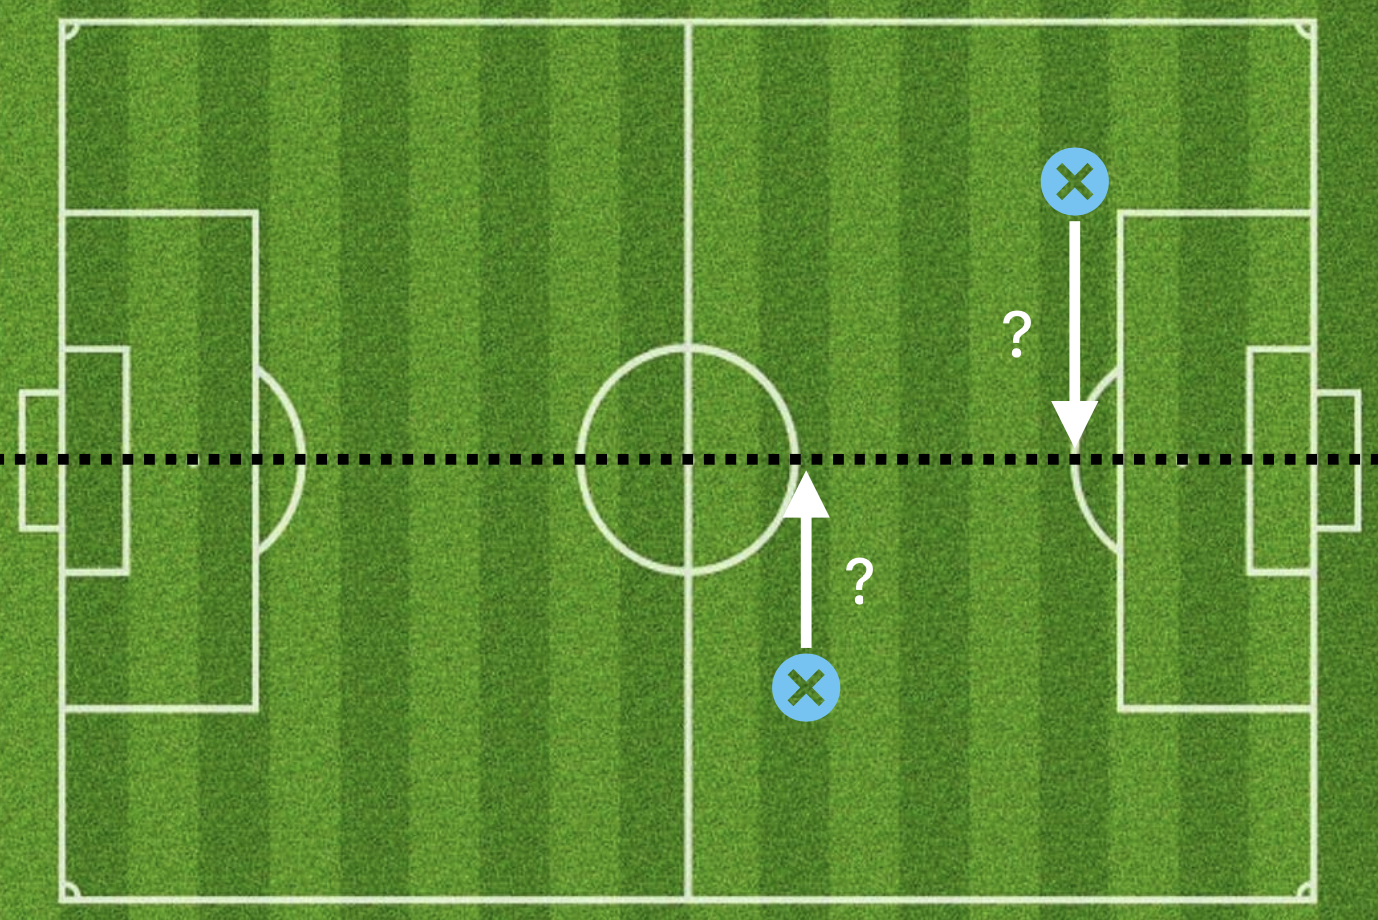

In [5]:
from IPython.display import Image
Image(filename='assets/improved_y_distance.png')

In [6]:
df_passes['distance_y_center'] = df_passes.apply(lambda row: distance_between_two_points(
                                        np.array([row.improved_destination_pos_x,row.improved_destination_pos_y])*pitch_dim,
                                        np.array([row.improved_destination_pos_x,0.5])*pitch_dim
                                                                                ),axis=1)

Finally, I wanted to introduce a new feature related to the interceptability of the pass. We had the position of the opponent team's players, so we could compute how easy it would be for any of them to intercept the ball. Again, there were many ways to do so, but it could become very complex if I tried to predict all the possible outcomes. Just as I did before, I chose a simpler solution that made a generic assumption in order to facilitate the computation of the feature. Most unsuccessful passes tended to be intercepted in a position close to the intended destination. So I assumed that if a defender could reach the supposed destination before the ball, the pass would likely be intercepted.

But before proceeding with this computation, I needed to perform a small fix. If I took a look at the dataset, I would see that there were some passes with a duration of 0 seconds. That was incorrect given that the distance of those passes was not 0. I replaced these wrong durations with the duration that would have taken for the pass if the ball travelled at the mean speed for passes. I completed the following 2 steps:
* Computed the mean speed of those passes with duration higher than 0s (remembering that speed is pass distance / duration)
* Recomputed the duration of the passes with original duration of 0s using the mean speed computed before and their pass distance.

In [7]:
df_speed = df_passes[df_passes['duration'] != 0][['duration','pass_distance']]
df_speed['speed'] = df_speed['pass_distance']/df_speed['duration']
mean_speed = df_speed['speed'].mean()

df_passes['duration'] = np.where(df_passes['duration'] == 0,df_passes['pass_distance']/mean_speed,df_passes['duration'])

The feature I computed regarding interceptability was the minimum speed needed for any defender to reach the intended pass destination before the ball. I first computed the distance to the improved destination for every defender, then picked the minimum one (closest defender) and finally divided it by the pass duration to obtain the speed needed to reach that point.

In [8]:
def closest_defender_distance(action):
    min_distance = 5000
    for player in eval(action['opponent_team_players']):
        distance = distance_between_two_points(np.array([player['norm_pos_x'],player['norm_pos_y']])*pitch_dim,
                                               np.array([action.improved_destination_pos_x, action.improved_destination_pos_y])*pitch_dim)
        if distance < min_distance:
            min_distance = distance
    return min_distance

df_passes['min_speed'] = df_passes.apply(lambda row: closest_defender_distance(row)/row.duration,axis=1)

## 2. Feature selection and dataset creation

I used only the 4 newly created derived features to build the final dataset, excluding the improved destination variables and the fixed duration. I created the X set (predictive variables) using these 4 features, and used the success variable to create the y set (response variable).

In [9]:
X = df_passes[['pass_distance','distance_y_center','min_speed','duration']]
y = df_passes.success

## There is no improve in performance by scaling the data
## since it is much easier to understand the data without it later on I will not use it
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(np.array(X)),columns=['pass_distance','distance_y_center','min_speed','duration'])
X

pass_distance  distance_y_center  min_speed  duration
0          13.580547          27.826542   4.801107  1.176486
1           8.722270           6.834101   3.542638  0.960000
2          15.911472          32.143904   9.011342  1.400000
3           5.539154          25.647570  15.243757  0.760000
4          12.082049          24.467009   9.031312  1.160000
...              ...                ...        ...       ...
38971      27.159616           2.010194   1.859003  2.640000
38972      15.938565          23.791475   3.818825  0.960000
38973      28.442064           1.553510   1.404095  2.160000
38974      28.615222           5.906054   1.028018  2.080000
38975      25.523519           3.762263   1.550261  2.160000

[38976 rows x 4 columns]

Next, I needed to split the sets into training and test sets in order to perform model selection in an objective and unbiased manner. To do so, I used _sklearn_'s method _train\_test\_split_. Note that the response variable was very unbalanced (more than 90% of passes were successful), which could create problems for the models. To smooth this unbalance effect, I made sure that at least all the splits we made on the data kept the same proportion of positives (% of successful passes). I did that by using the _train\_test\_split_'s _stratify_ parameter. I passed the response column as this parameter, and the method made sure to keep the proportions equal. I made the test_size as 1/3 of the dataset and fixed a random_state for replicability. I could have used other methods such as the class _StratifiedShuffleSplit_ as an alternative.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0, stratify=y) 

We needed an extra set of data called the calibration set for a future exercise. We explained later why it was useful, but we used the same method to split the obtained train_set into a new train_set and a calibration_set. This time we used 1/4 as the test_size. Note that in the end we had the following sets: X_test, y_test (33% of the total); X_train, y_train (75% of the remaining 66% -> 50% of the total); X_calibration, y_calibration (25% of the remaining 66% -> 17% of the total).

In [11]:
X_train, X_calibration, y_train, y_calibration = train_test_split(X_train, y_train, test_size=1/4, random_state=0, stratify=y_train)

## 3. Modeling

### 3.1. Decision tree

Once all the sets were ready, it was time to fit the model. I started by using the _DecisionTreeClassifier_ provided by _sklearn_. This model was used for multi-class classification which was the problem we were trying to solve in this peoject. In particular, we wanted to classify the passes as either successful or not successful. This model took several hyper-parameters (check the docs for more information), though we only focused on tuning some of them. The default values of many of the parameters were already optimized for most problems, so we left them as they were set to avoid long training times.

In order to find the best parameter combination, we performed a Grid Search cross-validation. This consisted of performing a 10-fold cross validation for every combination of hyper-parameter values. This way the scoring values obtained didn't depend so much on the chosen splits. Again, we wanted the cross-validation splits to be stratified in order to keep the response values proportions.

The metric used to compare the fitted models was _log loss_, since it works really well for probabilities. The model not only yielded a classification value (successful or not successful), but it also returned a probability of how confident it was regarding the classification. _Log loss_ took into account the yielded probability, so the model was evaluated by the response and also by its confidence. We used the negative log loss in the code below because the goal was to minimize the log loss, but the generic objective of GridSearchCV was to maximize the metric.

In [12]:
# Hyper-parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 8)
}

# Model initialization
tree_model = tree.DecisionTreeClassifier(random_state=1234)
# Grid search configuration. We will use log loss as the scoring metric to compare the models and a 10-fold stratified cross-validation
tree_gs_cv = GridSearchCV(tree_model, param_grid, scoring='neg_log_loss', cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True))
# Fitting the training data
tree_gs_cv.fit(X_train, y_train)

# Printing the best hyper-parameter combination and the best score
tree_gs_cv.best_params_, tree_gs_cv.best_score_

({'criterion': 'entropy', 'max_depth': 4}, -0.19461092879231542)

One of the most important hyper-parameter values was the max depth, which determined the depth of the generated tree. The deeper the tree, the more complex the model became. More complex trees could capture more complex relations between variables, but there was always the risk of over-fitting the model to the training data. In addition, the more complex the tree, the harder it was to interpret its results.

The following code generated a PNG with the structure of the tree fitted before. I used this code to plot the structure of trees fitted with different configurations and observed how they changed. I tried to understand how it worked and described with my own words the decision made at each node of one of the trees I produced. I used a simple tree (not too deep) for the explanation.

In [13]:
Path("./output/").mkdir(parents=True, exist_ok=True)

dot_data = tree.export_graphviz(
    tree_gs_cv.best_estimator_, out_file=None,
    feature_names=X_train.columns.values.tolist(),
    class_names=[str(c) for c in tree_gs_cv.best_estimator_.classes_],
    filled=True, rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('output/decision_tree')

'output\\decision_tree.png'

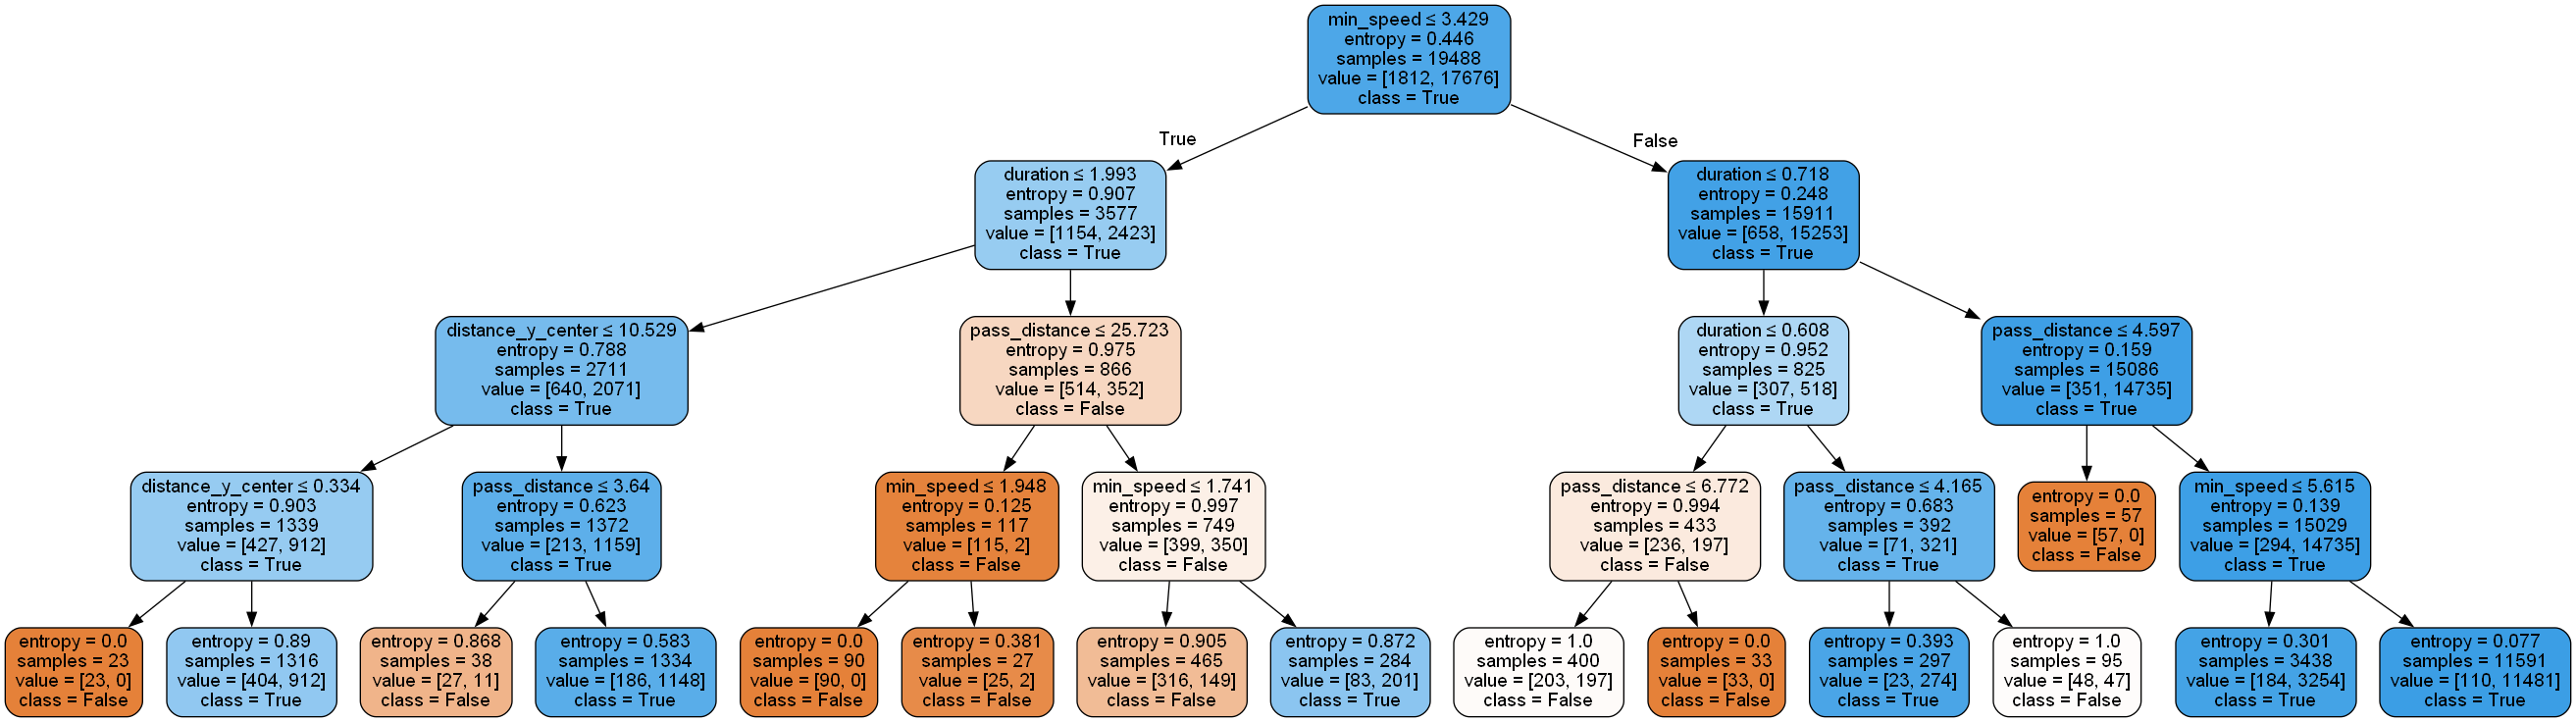

In [14]:
Image(filename='output/decision_tree.png')

Above we can observe the resulting Tree classifier of the passes. Depending on the different values for different split values, the passess will predicted to be successful or not. It can be observed all leafs are in the last level, except for one in the righ side of the image which is in the level above. Because it is the shortest one, I will use that one to explain the results of the passes that follow that path and end up classified as unsuccessful passes.

Overall, we can see that the orange coloured boxes are the unsuccessful passes while the blue ones are the successful ones (here entropy < 1 but if Entropy is 0, then all samples are correctly labeled). The white ones are the ones which are closer to a 50-50 split (entropy = 1) and would require further tree levels to fully determine which classification to assign it to. As we can see, in the selected leaf, all the 57 samples end up being Unsuccessful and correctly labeled.

If we start at the first node (root), we do a split based on the minimum speed required by the defender to reach the ball before an attacker. The threshold is stablished at 3.429. All samples with less or equal speed required are labeled as successful (True) in this first step, and the larger ones are classified also as successful, since the majority of the samples are also successful. As it can be seen the entropy score at the root is kind of low, less than 0.5, so it means that it may be normal that it results in 2 successful labels since there are more of them. For the second step, we focus on the second branch of the tree, and in this case we are going to split the samples based on the duration of the pass. In this case we have again a case where both childs end up being classified as True. The threshold is established at 0.718. Smaller or equal goes to left-chils while bigger ones to right-child, which is our next focus for the third level. 

In this final split, we get finally a group of samples that are classified as unsuccessful passes. The selected variable was pass_distance. Passes larger than 4.597 go to the right-child and classified as successful. However, the ones that have less distance are classified as unsuccessful passes, and all the samples going into this node and that is why the entropy is 0, because there is no mix of 2 different classes. In the end, the passes that end up in this node have the following statistics:

- min_speed > 3.429
- duration > 0.718
- pass_distance >= 4.597

So, if a pass satisfies this conditions, it will be classified as Unsuccessful. This can be done for any pass, where by following each condition at each node, we can check which will be the end label, which is one of the great features of Decision Trees, because it is really easy to explain and interpret the results.

I printed the log loss of both the training set and the test set for the final tree built. The _log\_loss_ function provided by _sklearn_ was used to compute it. For both sets, the original responses and the new ones predicted by the model were used. The new ones were obtained using the _predict\_proba_ method of the GridSearch's _best\_estimator\__. We checked if both losses differed a lot to see if the model had over-fitted.

In [15]:
logloss_train = log_loss(y_train, tree_gs_cv.predict_proba(X_train))
logloss_test = log_loss(y_test, tree_gs_cv.predict_proba(X_test))
logloss_train, logloss_test

(0.18509172470132218, 0.19259679117865522)

### 3.2. Random Forest

We then tried a second kind of tree-based model. Random Forests combine 2 different techniques to make Decision Trees much more powerful. We used ensembling and bagging, which consist on combining the predictions of many trees and building and bootstrapping them correspondingly.

In [16]:
param_grid = {
    "n_estimators": [1500],
    'criterion': ['entropy'],
    'max_depth': [4]
}

rf_tree_model = RandomForestClassifier(random_state=1234)
rf_tree_gs_cv = GridSearchCV(
    rf_tree_model, param_grid=param_grid, scoring='neg_log_loss',
    cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True), verbose=2
)
rf_tree_gs_cv.fit(X_train, y_train)

rf_tree_gs_cv.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.7s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.1s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.3s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.5s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.4s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  25.3s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  24.4s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  25.5s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  25.9s
[CV] END ..criterion=entropy, max_depth=4, n_estimators=1500; total time=  27.4s


{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 1500}

I printed again the log loss of the new estimator for the train and test sets. I also noticed that without tuning many hyperparameters, we were already improving the performance.

In [17]:
logloss_train = log_loss(y_train, rf_tree_gs_cv.predict_proba(X_train))
logloss_test = log_loss(y_test, rf_tree_gs_cv.predict_proba(X_test))
logloss_train, logloss_test

(0.18235739849965002, 0.18204834853620683)

### 3.3. XGBoost

In addition to the decision tree and random forest models we have already tried, we also experimented with XGBoost, another tree-based model. XGBoost has gained popularity due to its excellent performance even without much hyper-parameter tuning. However, its structure is less interpretable than the decision tree seen earlier because it is more complex. Later, we will explore other methods for interpreting its results. We will see how much it improves the performance metrics, but we stuck to just one combination because this type of model takes longer to fit.

In [18]:
param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [1500],
    "max_depth": [4],
}

xgb_tree_model = XGBClassifier(eval_metric="logloss", random_state=1234, use_label_encoder=False, verbosity=1)
xgb_tree_gs_cv = GridSearchCV(
    xgb_tree_model, param_grid=param_grid, scoring='neg_log_loss',
    cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True), verbose=2
)
xgb_tree_gs_cv.fit(X_train, y_train)

xgb_tree_gs_cv.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.1s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.2s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  11.1s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  11.9s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.1s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  11.8s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.1s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.0s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.6s
[CV] END ..learning_rate=0.1, max_depth=4, n_estimators=1500; total time=  12.3s


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1500}

Then, we computed the log loss for the training and test sets as we did before, but this time using the XGBoost model trained.

In [19]:
logloss_train = log_loss(y_train, xgb_tree_gs_cv.predict_proba(X_train))
logloss_test = log_loss(y_test, xgb_tree_gs_cv.predict_proba(X_test))
logloss_train, logloss_test

(0.006136780736568026, 0.026623906543775853)

### 3.4. Calibration

When predicting probabilities, it is important to make sure that the yielded results are reliable percentages. That can be checked by grouping those passes that have similar predicted probabilities and asserting that the percentage of them that are successful is close to their mean predicted value. This is what the calibration curve illustrates.

#### 3.4.1. Calibration curve

The following method plots the calibration curve of a provided classifier for both the train and test sets. The plot consists of grouping the passes of each set into a number of bins (we used 10) and for each bin, drawing a point using its mean predicted value as the value of the x axis and the fraction of successful passes as the value of the y axis. Ideally, the points should have formed a straight line going from the lower left part of the plot to the upper right part (as the dotted line).

There were 2 different strategies to form the bins. The _uniform_ strategy (default) divided the range of values (0 to 1) into N (10) different equally-sized intervals. So in this case, the first bin contained those passes with a predicted probability between 0 and 0.1, the second those between 0.1 and 0.2, and so on. This strategy worked well when we assumed that the distribution of the yielded probabilities was uniform (which was not the case).

The _quantile_ strategy produced bins with equal numbers of samples in each of them. The passes were sorted by the predicted probability, and the initial _total\_passes / N_ passes fell onto the first bin. This strategy did take into consideration the data's distribution.

In [20]:
def plot_calibration_curve(clf, X_train_, y_train_, X_test_, y_test_, strategy="uniform"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    y_pred_train = clf.predict_proba(X_train_)[:,1]
    y_pred_test = clf.predict_proba(X_test_)[:,1]

    log_score_train = log_loss(y_train_, y_pred_train)
    log_score_test = log_loss(y_test_, y_pred_test)

    print(" - Log Loss Train: %1.3f" % log_score_train)
    print(" - Log Loss Test: %1.3f" % log_score_test)

    for y_set, prob_pos, log_score, subname in [(y_train, y_pred_train, log_score_train, 'train'), (y_test, y_pred_test, log_score_test, 'test')]:
        fraction_of_positives, mean_predicted_value = calibration_curve(y_set, prob_pos, n_bins=10, strategy=strategy)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (subname, log_score))
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=subname, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plot (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

I then produced the calibration curves for the 3 tree-based models trained before (decision tree, random forest and XGBoost) and tried both strategies for each of them. I noticed that for the _uniform_ strategy, the calibration does not work well when there is very few data. With few data the computed calibration values are not very reliable. It's important to note that the plot illustrated below the curve corresponds to the histogram of the predicted probabilities.

 - Log Loss Train: 0.185
 - Log Loss Test: 0.193
 - Log Loss Train: 0.185
 - Log Loss Test: 0.193


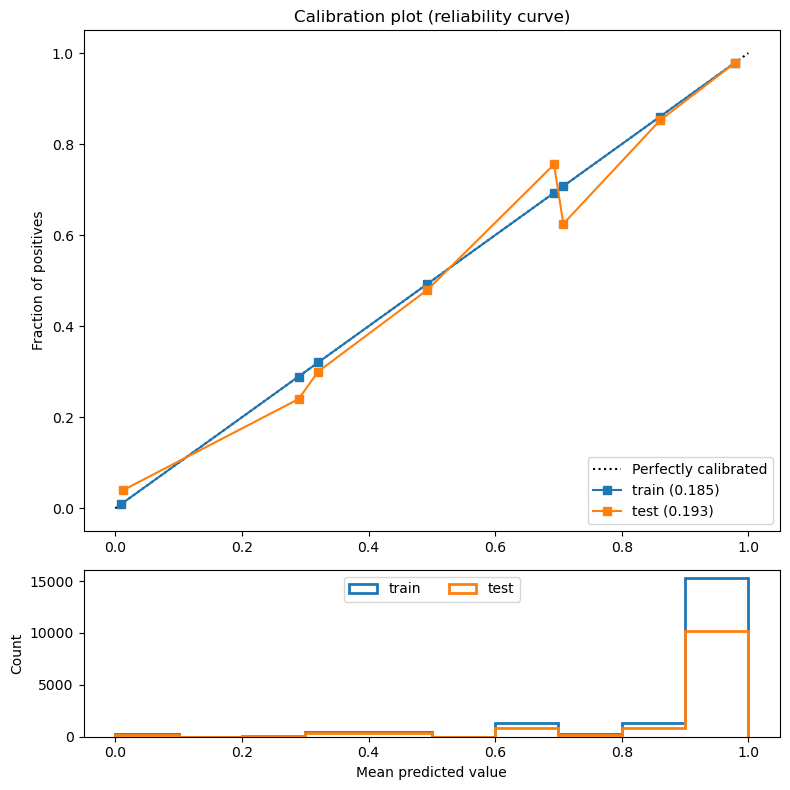

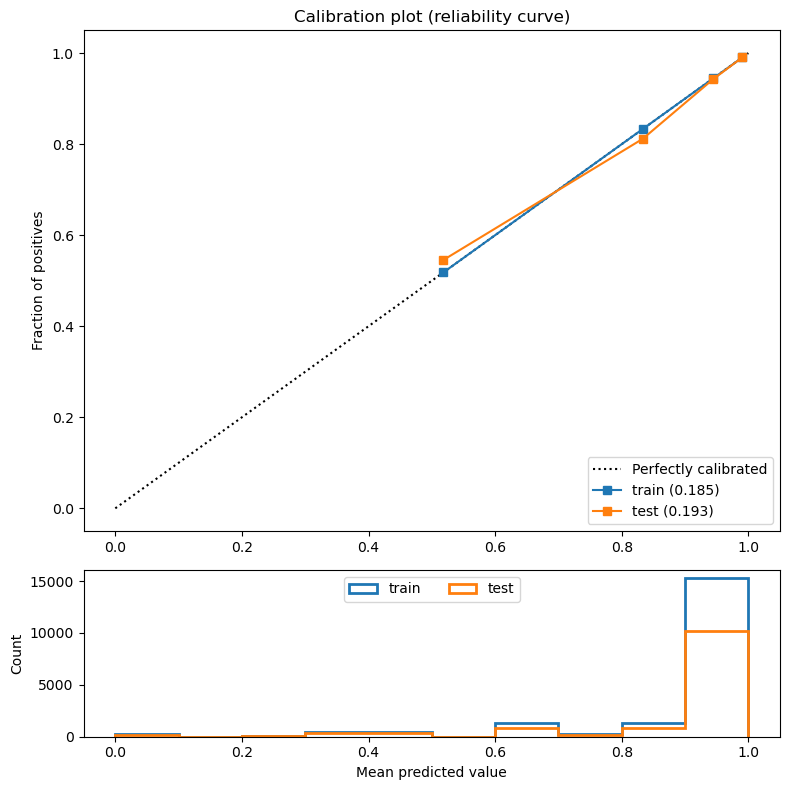

In [21]:
plot_calibration_curve(tree_gs_cv, X_train, y_train, X_test, y_test, strategy="uniform")
plot_calibration_curve(tree_gs_cv, X_train, y_train, X_test, y_test, strategy="quantile")

 - Log Loss Train: 0.182
 - Log Loss Test: 0.182
 - Log Loss Train: 0.182
 - Log Loss Test: 0.182


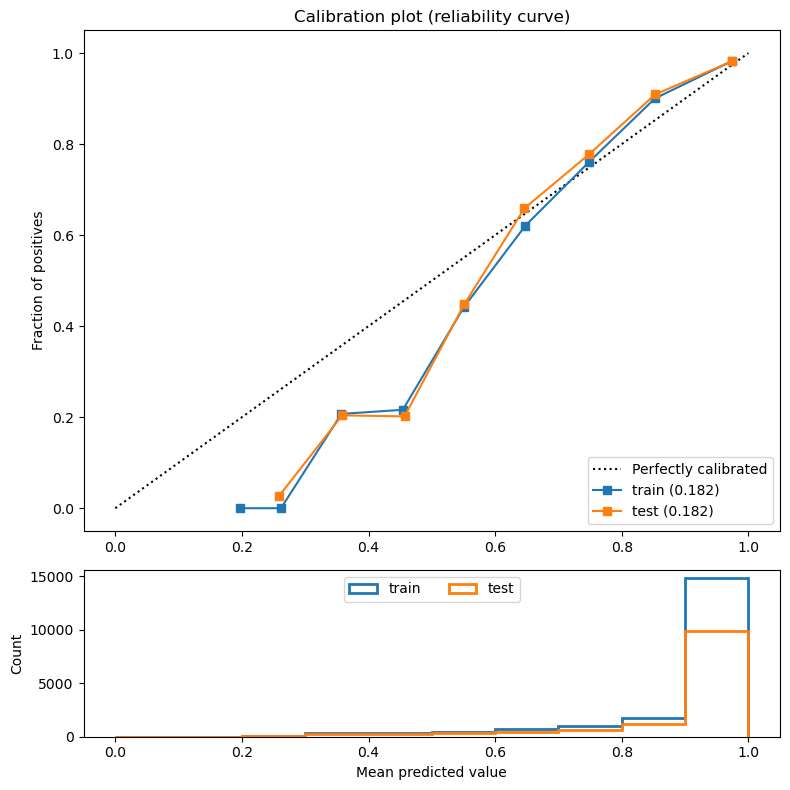

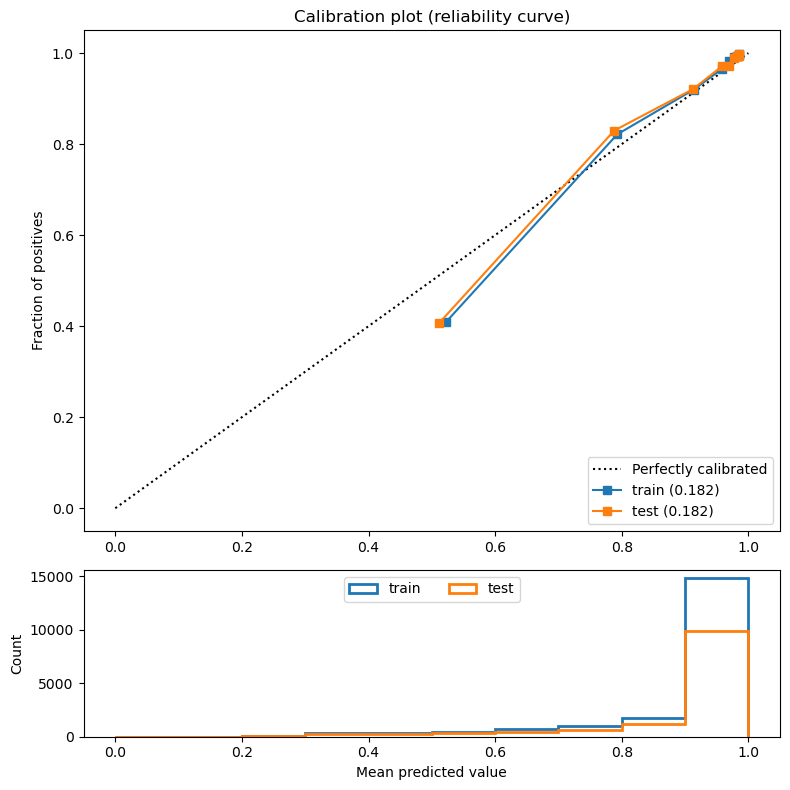

In [22]:
plot_calibration_curve(rf_tree_gs_cv, X_train, y_train, X_test, y_test, strategy="uniform")
plot_calibration_curve(rf_tree_gs_cv, X_train, y_train, X_test, y_test, strategy="quantile")

 - Log Loss Train: 0.006
 - Log Loss Test: 0.027
 - Log Loss Train: 0.006
 - Log Loss Test: 0.027


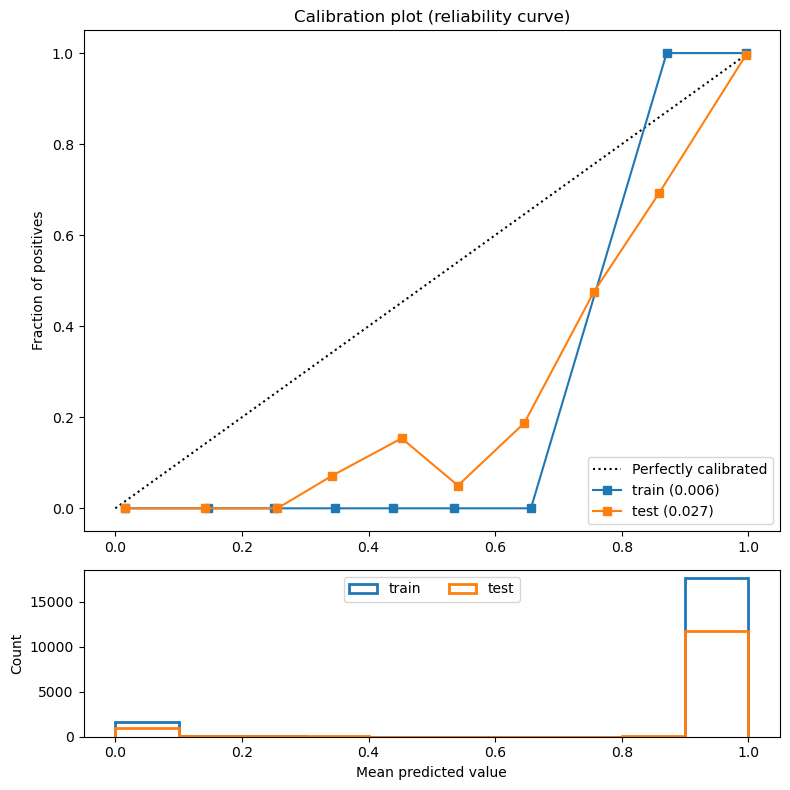

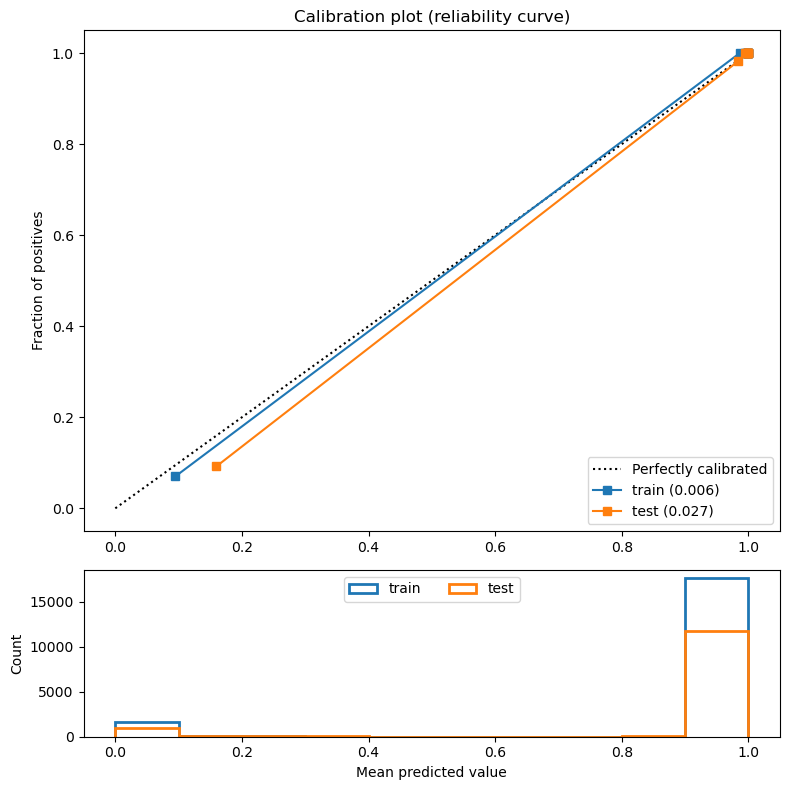

In [23]:
plot_calibration_curve(xgb_tree_gs_cv, X_train, y_train, X_test, y_test, strategy="uniform")
plot_calibration_curve(xgb_tree_gs_cv, X_train, y_train, X_test, y_test, strategy="quantile")

#### 3.4.2. Post-calibration

There are methods applied to already fitted classifiers in order to improve their calibration. These methods are known as post-calibration methods. They use data not previously seen by the model (that would introduce bias) to fit a regressor that maps the output of the initial classifier to a calibrated probability. That is why we previously needed to divide the original training set into a new training set and a calibration one. The following code produces a new model that produces more calibrated outputs. We used as a parameter the best estimator produced we obtained from the XGBoost grid search cross-validation.

In [24]:
calibrated_xgb_tree = CalibratedClassifierCV(
    xgb_tree_gs_cv.best_estimator_, cv="prefit", n_jobs=-1, method="isotonic"
).fit(X_calibration, y_calibration)

I checked it by plotting the calibration curve of the calibrated model using the _quantile_ strategy and compared it to the one produced for the original XGBoost. Note that the performance metric may have worsen a little bit, but the calibration should have overall improved.

 - Log Loss Train: 0.002
 - Log Loss Test: 0.037


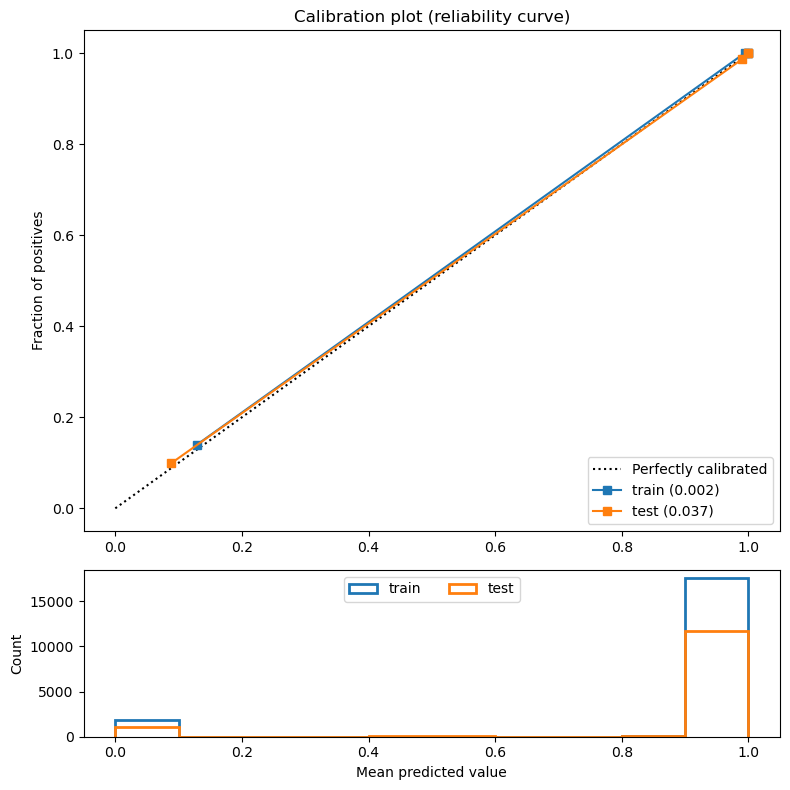

In [25]:
plot_calibration_curve(calibrated_xgb_tree, X_train, y_train, X_test, y_test, strategy="quantile")

### 3.5. SHAP

As mentioned before, there are alternative methods to interpret the results provided by certain models. SHAP is a very optimized framework that allows to explain the output of any machine learning model. It works specially well for tree-based models, which is what we have worked with in this project.

In [26]:
shap.initjs()

In [43]:
explainer = shap.TreeExplainer(calibrated_xgb_tree.estimator, method="approximate")
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The following plot shows the impact each model feature has on the provided probability. The features with higher impact are determined as more important by the model.

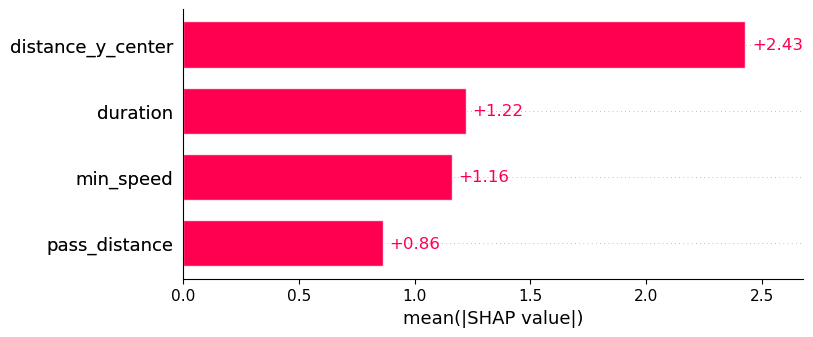

In [44]:
shap.plots.bar(shap_values)

Similarly, the beeswarm plot tries to illustrate the same concept. This time though, it differentiates between positive and negative impact (increasing or decreasing the yielded probability) and it also shows whether the feature's value is high or low when it impacts the result. Blue points on the left will mean that low values of that feature make the pass success probability decrease, whereas right points on the right will refer to the opposite (high feature values produce an increase in the probability).

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


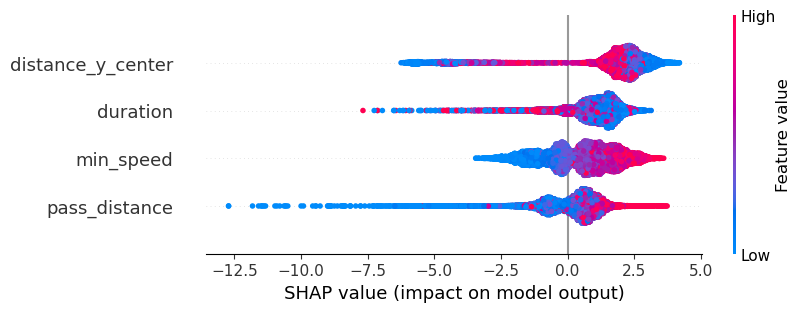

In [45]:
shap.plots.beeswarm(shap_values)

If we analyse the three charts above generated by SHAP Tree Explainer we can see which are the most important variables and what values support producing positive or negative results when predicting a pass success probability.

**First plot**

In terms of feature importance, we see the most important one by far (twice as important as 2nd and 3rd feature) it is the distance to the centre of the pitch (from side-to-side). Then we have to almost equally important ones being the duration of the shot and the minimum speed required for a defender to reach the ball destination. Finally the feature that has least importance is the pass distance.

**Second plot**

In the beeswarm plot we can see and differentiates between positive and negative impact of each variable. About the distance to the center, we can actually see something not so normal. We see low distances are at both ends, with some having big impact and the others low impact; and the high features values being more around the center. This makes quite some sense, since teams normally will defend the center of the pitch more than the sides for example. So it will be easier. However, passes on the center are also harder for a defending team to intercept because attacking teams tend to do very secure and low risk passes. And in between those 2 cases, we see passes that are on the sides, which are riskier than the easy center field passes and therefore easier to intercept but also are harder to intercept than the riskier passes in the center because there is more people defending the center.

The duration is also a bit hard to explain since it is also mixed. Nevertheless we can see that overall the high impact is given by low duration. therefore, passes that may be short or being hit with a high speed, which makes a lot of sense since the defender will have less time to intercept the ball. Opposite to this one, but also related to it, we can see the higher the min speed required by the defnender to intercept the ball, the higher the impact on a successful pass. This is expected, since it will therefore be harder to reach to the ball sooner than the attacker.

In last place we have the pass distance. As seen it is the least impactful variable, and the higher the distance the more positive impact it has, and the lower the distance the more negative impact it has on the prediction. This is a bit surprising since you would imagine larger passes are riskier. However, I believe this is due to the fact that larges passes tend to be made in safer and less risky zones of the pitch. Like in buildup a large pass from a center-back to a full-back. On the other hand, in progression or finishing stages of the game passes tensd to be shorter and normally are easier to be intercepted. Not because they are short, but because the area of the pitch where they are being generated is where most defenders are placed, and where they put the most energy.

Finally, we can plot the impact of the features on a single pass. We tried it for different passes on the dataset to observe how each feature's impact varies from one example to another.

In [46]:
for i in range(1,12):
    display(shap.plots.force(shap_values[i]))

In this different cases, we can see how the difference between short, medium, and large values of distance to the center have impacted the results. We show an example wherre a distance of around 14 has a high positive impact on the pass probability while in the last one we see a 15 value being a quite high negative impact. Then we see that overall a high pass distance and min speed required by the defender results in a higher impact outcome while a higher duration preduces more negative results than higher ones, which is aligned with what we saw in the beeswarm plot.

Overall, we can see all the cases are aligned with the other 2 plots above, also showing the "strange" phenomenon happening with the distance to the center.